In [27]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange


import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl


import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
#import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd



import numpy
import warnings
import functools
import pickle
import time



In [3]:
# File Reading Code

def get_duke_proj(index, lesion):
    if lesion:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+str(index)+".mat")["head"]
    else:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/"+str(index)+".mat")["head"]
    testvol = np.rollaxis(a, 2, 0)
    testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
    
    testvol[testvol == 0.80] = 0.81
    print(np.unique(testvol.flatten()))
    
    testvol = testvol/65
    proj_arr         = W*testvol
    
    # All Flags
    insert_noise     = 1
    if insert_noise:
        I0        = 1000
        proj      = I0*np.exp(-proj_arr)
        proj_noi  = np.random.poisson(proj)
        proj_noi[proj_noi == 0] = 1
        g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
        g_noi[g_noi < 0]        = 0
        proj_arr = g_noi
    
    temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
    temp_proj = np.rollaxis(temp_proj, 0, 2)
    #print(temp_proj.shape)
    return temp_proj

def load_prj_raw(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []
    
    start_angle = -21.30
    
    proj_paths = glob.glob("/media/dril/Windows/mcgpu1/projections_without_fsm"+projection_name+"/*.raw")
    proj_paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    for p in proj_paths:
        print(p)
        
        if '.0000.' in p:
            continue
        
        a    = np.fromfile(p, dtype='float32')#pydicom.dcmread(p)
        a    = np.reshape(a, [2, 1504, 3000])
        temp = a[0, :, :]#.pixel_array.T
        temp = np.log(10000000)-np.log(temp)
        
        if(0):
            # Sharpening filter
            temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
            thresh_min      = threshold_minimum(temp)
            binary_adaptive = temp > thresh_min
            temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
            print(temp.shape)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(start_angle)
        start_angle = start_angle + 1.92
    
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def load_prj_ima(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []

    proj_paths = glob.glob("/media/dril/ubuntudata/DBT_recon_data/"+projection_name+"/CE*.IMA")
    for p in proj_paths:
        if '.0000.' in p:
            continue
        
        a    = pydicom.dcmread(p)
        temp = a.pixel_array.T
        temp = np.log(10000)-np.log(temp)
        # Sharpening filter
        temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
        thresh_min      = threshold_minimum(temp)
        binary_adaptive = temp > thresh_min
        temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(float(a[0x00181530].value))
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def import_param():
    for i in range(ANGLES):
        index[i] = i
    return index

def load_prj():
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        filename = basepath + filepath+str(s).zfill(4)#+'.raw'
        
        with open(filename, 'rb') as f:
            primary_plus_scatter  = np.fromfile(f, dtype=np.float32)
            host_prj_temp1        = primary_plus_scatter[:b_size]
            host_prj_temp2        = primary_plus_scatter[b_size:]
        
        host_prj_1view_temp = x_y_flip(host_prj_temp1)
        host_sct_1view_temp = x_y_flip(host_prj_temp2)
        
        print(host_prj_1view_temp.shape)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = host_prj_1view_temp[i]
            scat_allangle[flag2*BINSx*BINSy + i] = host_sct_1view_temp[i]
        
        flag2 = flag2+1
    return prj_allangle, scat_allangle
    
def load_prj_std(data_type):
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    #scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        
        if data_type   == 0:
            #filename = basepath + 'OSTR_prelog/'+projection_name+str(s).zfill(4)#+".raw"
            filename = basepath + 'Projections_Renamed_Seg/'+projection_name+str(s).zfill(4)#+".raw"
        elif data_type == 1:
            filename = basepath + 'OSTR_scatter/'+scatter_name+str(s).zfill(4)#+".raw"
        else:
            filename = basepath + 'OSTR_blank/'+blank_name+str(s).zfill(4)#+".raw"
        
        #print(filename)
        with open(filename, 'rb') as f:
            #data  = np.load(f)
            data  = np.fromfile(f, dtype=np.float32)
            # If doign SART
            #data  = np.log(10000) - np.log(data)
            
            #print(data.shape)
            #data  = np.reshape(data, (1400, 3584))
            #data  = data[:1400, :]
            #data  = np.flip(data, 0)
            #data  = data.flatten()
            #print(data.shape)
                #data  = np.fromfile(f, dtype=np.float32)
        #np.save(filename+'.npy', data)
        proj = x_y_flip(data)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = proj[i]
        
        flag2 = flag2+1
    
    return prj_allangle


In [4]:
# [STAR] CNN Models

def rating_cnn(input_size = (256, 256, 1)):
    filter1 = 4
    filter2 = 4
    filter3 = 4
    filter4 = 4
    
    input1 = Input(input_size)
    
    conv1 = Conv2D(filter1, 3, padding = 'same',kernel_initializer = 'glorot_normal')(input1)
    conv1 = LeakyReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #conv1 = Dropout(0.2)(conv1)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv1)
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #conv2 = Dropout(0.2)(conv2)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #conv2 = Dropout(0.2)(conv2)
    
    conv3 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv2)
    conv3 = LeakyReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #conv3 = Dropout(0.2)(conv3)
    
    conv4 = Conv2D(filter4, 3, padding = 'same', kernel_initializer = 'glorot_normal')(conv3)
    conv4 = LeakyReLU()(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    out1 = Flatten()(conv4)
    #out1 = Dropout(0.3)(out1)
    
    #out2 = Dense(64, kernel_initializer = 'glorot_normal')(out1)
    #out2 = LeakyReLU()(out2)
    #out2 = Dropout(0.3)(out2)
    
    #out3 = Dense(32,  kernel_initializer = 'glorot_normal')(out2)
    #out3 = LeakyReLU()(out3)
    
    out3 = Dense(1, activation="sigmoid")(out1)
    
    model  = Model(input = input1, output = out3)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_vanilla(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    #input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dense(32, activation='relu')(hash_val)
    #hash_val = Dense(1, activation='relu')(hash_val)
    
    #input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    #drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    #conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    #conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    #conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = input1, output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_two(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dropout(0.3)(hash_val1)
    hash_val1 = Dense(32, activation='relu')(hash_val1)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val1, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val1, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val1, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4, up6], axis = 3)
    
    
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_no_dense(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dropout(0.3)(hash_val)
    #hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = input2#Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

def unet_combined(pretrained_weights = None, input_size = (128, 128, 1)):
    base_model  = unet()
    base_model.load_weights("all-data-0-to-7-0.0005-5.h5")

    filter1 = 32
    filter2 = 32
    filter3 = 32
    
    input1 = Input(input_size)
    input2 = Input(input_size)
    
    input1_1 = Input((1, ))
    input1_2 = Input((1, ))
    input1_3 = Input((1, ))
    input1_4 = Input((1, ))
    input1_5 = Input((1, ))
    input1_6 = Input((1, ))
    input1_7 = Input((1, ))
    
    for t in base_model.layers:
        t.trainable = False
    
    w1    = Concatenate()([input1, input2])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(w1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    layer_output = base_model.layers[-4].output
    
    new_model    = Model(base_model.input, layer_output)
    
    r1 = new_model([input1, input1_1])
    r2 = new_model([input1, input1_2])
    r3 = new_model([input1, input1_3])
    r4 = new_model([input1, input1_4])
    r5 = new_model([input1, input1_5])
    r6 = new_model([input1, input1_6])
    r7 = new_model([input1, input1_7])
    
#     c1 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 0])(conv1))
#     c2 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 1])(conv1))
#     c3 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 2])(conv1))
#     c4 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 3])(conv1))
#     c5 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 4])(conv1))
#     c6 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 5])(conv1))
#     c7 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 6])(conv1))
    
    
#     q1 = Multiply()([conv1, r1])
#     q2 = Multiply()([conv1, r2])
#     q3 = Multiply()([conv1, r3])
#     q4 = Multiply()([conv1, r4])
#     q5 = Multiply()([conv1, r5])
#     q6 = Multiply()([conv1, r6])
#     q7 = Multiply()([conv1, r7])
    
    #ut   = Add()([q1, q2, q3, q4, q5, q6, q7])
    #ut   = Add()([c1, c2, c3, c4, c5, c6, c7])
    out   = Add()([r1, r2, r3, r4, r5, r6, r7])
    out   = Multiply()([conv1, out])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    out   = LeakyReLU(0.2)(conv1)
    
    #conv1 = Multiply()([hash_val, conv1])
    
    model1  = Model(input = [input1, input2, input1_1, input1_2, input1_3, input1_4, input1_5, input1_6, input1_7], output = out)
    
    model1.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model1

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

from skimage import measure

device = torch.device("cuda:0")

# in1 = np.ones([10, 1, 256, 256])
# in2 = np.ones([10, 1])

# in1 = torch.tensor(in1, device=device).float()
# in2 = torch.tensor(in2, device=device).float()


# Define model
class MyUnetGN(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
        
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU())
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter1//2, filter1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter2//2, filter2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter3//2, filter3))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter4//2, filter4))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter5//2, filter5))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(filter4//2, filter4))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(filter3//2, filter3))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(filter2//2, filter2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(filter1//2, filter1))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter4//2, filter4))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter3//2, filter3))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter2//2, filter2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.GroupNorm(filter1//2, filter1))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.1)
        self.d2 = nn.Dropout(0.1)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetBN(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
        
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU())
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter3))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter4))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter5))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter4))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter3))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter1))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter4))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter3))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            nn.BatchNorm2d(filter2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2filter1
            nn.BatchNorm2d(filter1))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.1)
        self.d2 = nn.Dropout(0.1)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetSlice1(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        hash_val1 = self.dense_block(v)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetSlice1_half(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 16
        filter2 = 32
        filter3 = 64
        filter4 = 128
        filter5 = 256
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        hash_val1 = self.dense_block(v)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetSlice2(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        hash_val1 = self.dense_block(v)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        #hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val1)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val1)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val1)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out
    
class MyUnetSlice2_half(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 16
        filter2 = 32
        filter3 = 64
        filter4 = 128
        filter5 = 256
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        hash_val1 = self.dense_block(v)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        #hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val1)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val1)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val1)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetSlice3(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val1 = self.dense_block(y)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        hash_val = self.dense_block(v)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        #hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val1)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val1)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val1)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnetSlice4(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block1 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block2 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block3 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block4 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.dense_block5 = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        #self.d1 = nn.Dropout(0.5)
        #self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y, v):
        hash_val1 = self.dense_block1(y)
        hash_val1 = hash_val1.view(-1, 1, 1, 1)
        
        hash_val2 = self.dense_block2(y)
        hash_val2 = hash_val2.view(-1, 1, 1, 1)
        
        hash_val3 = self.dense_block3(y)
        hash_val3 = hash_val3.view(-1, 1, 1, 1)
        
        hash_val4 = self.dense_block4(y)
        hash_val4 = hash_val4.view(-1, 1, 1, 1)
        
        hash_val5 = self.dense_block5(y)
        hash_val5 = hash_val5.view(-1, 1, 1, 1)
        
        #hash_val = torch.mul(hash_val, hash_val1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val1)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val2)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val3)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val4)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val5)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val4)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val3)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val2)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnet_half(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 16
        filter2 = 32
        filter3 = 64
        filter4 = 128
        filter5 = 256
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class MyUnet_double(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 64
        filter2 = 128
        filter3 = 256
        filter4 = 512
        filter5 = 1024
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(0.2),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU(0.2)
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out

class RatingModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block3 = nn.Sequential(
            #nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            #nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2))
        
        self.out = nn.Sequential(nn.Linear(256, 1),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        x = x.view(-1, 256)
        x = self.out(x)
        
        return x

# Initialize model
#model = MyUnet()
#model.cuda()

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

#model.apply(init_normal)

#unet_model = MyUnetGN()
#unet_model.cuda()

# rating_cnn = RatingModel()
# rating_cnn.cuda()

#rating_cnn.apply(init_normal)
#summary(unet_model, [(1, 256, 256), (1, 1)])

# m = rating_cnn()
# print(m.summary())

In [ ]:
# [STAR] Getting patches for each lesion for training the calibaration CNN with lesions

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

unet_model.eval()

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

#print(val_list)


for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim = []
        all_haar = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        
        px = random.randint(500, 800)
        rx = random.randint(1500, 2000)
        tx = random.randint(25, 35)
        
        for tp in range(1, 2):
            #tx = 0
            #rx = 0
            temp = vol[tx, -128+px:128+px, -128+rx:128+rx]
            #temp = vol[h[k][3]+tp+tx, h[k][2]-128+rx:h[k][2]+128+rx, h[k][1]-128+rx:h[k][1]+128+rx]
            #print(temp.shape)
            if temp.shape[0] == 256 and temp.shape[1] == 256:
                x.append(temp)
                values.append(0)

        locations_array = []
        locations_flag  = 0

        allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
        allpaths.sort()

        print(allpaths[0])

        for t in allpaths:
            #print(t)
            s = float(t.split("/")[-1].split("-")[-1].split("_")[0])

            vol  = np.load(t)
            vol  = np.reshape(vol, [64, 1200, 3000])

            temp_count      = 0

            for tp in range(1, 2):
                #for dx in dx_array:
                    #for dy in dy_array:
                #rx = 0
                #tx = 0
                temp = vol[tx, -128+px:128+px, -128+rx:128+rx]
                #temp = vol[h[k][3]+tp+tx, h[k][2]-128+rx:h[k][2]+128+rx, h[k][1]-128+rx:h[k][1]+128+rx]
                #print(temp.shape)
                #temp = vol[h[k][3]+tp, h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy]
                #print(temp.shape)
                if temp.shape[0] == 256 and temp.shape[1] == 256:
                    x.append(temp)
                    values.append(s)

                    #print(s)
                    pp1 = np.expand_dims(x[0], 0)
                    pp1 = np.expand_dims(pp1,  0)
                    pv1 = np.expand_dims(-1*s, 0)
                    #print(pp1.shape, pv1.shape)

                    pp1 = torch.tensor(pp1, device=device).float()
                    pv1 = torch.tensor(pv1, device=device).float()

                    result = unet_model.forward(pp1, pv1).data.cpu().numpy()
                    all_outputs.append(result)
                    #ssim_temp = measure.compare_ssim(result[0, 0, :, :].astype('float32'), temp.astype('float32'), data_range=temp.max() - temp.min())
                    t1 = np.min(result[0, 0, :, :].flatten())
                    t2 = np.max(result[0, 0, :, :].flatten())
                    distorted_image  = (result[0, 0, :, :]-t1)*255/(t2-t1)

                    t1 = np.min(temp.flatten())
                    t2 = np.max(temp.flatten())
                    reference_image = (temp-t1)*255/(t2-t1)

                    ssim_temp = measure.compare_ssim(reference_image.astype('float32'), distorted_image.astype('float32'), 255)
                    #print(temp.max(), temp.min(), temp.max() - temp.min())

                    ssim_temp1 = haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True)[0]
                    all_haar.append(ssim_temp1)
                    all_ssim.append(ssim_temp)
                    #print(temp.shape, result.shape, ssim_temp, ssim_temp1)

        x      = np.array(x)
        values = np.array(values)
        all_outputs = np.array(all_outputs)
        all_outputs = all_outputs[:, 0, 0, :, :]

        #print(x.shape, values.shape, all_outputs.shape)
        break

    #plt.figure(figsize=(40,20))
    #plt.axis('off')
    tp1 = [x[1], x[3], x[4], x[5], x[6], x[7]]
    tv1 = np.array([values[1], values[3], values[4], values[5], values[6], values[7]])
    tv1[tv1 > 0.6] = 0.6

    ssim_arr = [all_ssim[1-1], all_ssim[3-1], all_ssim[4-1], all_ssim[5-1], all_ssim[6-1], all_ssim[7-1]]
    haar_arr = [all_haar[1-1], all_haar[3-1], all_haar[4-1], all_haar[5-1], all_haar[6-1], all_haar[7-1]]

    #plt.imshow(np.concatenate(tp1, axis=0).T, cmap='gray')

    print(values)
    print(tv1)
    print(ssim_arr)
    print(haar_arr)

    tp2 = [all_outputs[1-1], all_outputs[3-1], all_outputs[4-1], all_outputs[5-1], all_outputs[6-1], all_outputs[7-1]]


    f = plt.figure()
    plt.rcParams["figure.figsize"] = [9.6, 3.4]

    #gs1 = gridspec.GridSpec(1, 8)
    #gs1.update(wspace=0.025, hspace=0.05)

    plt.rcParams["font.family"] = "Times New Roman"

    fig, axs = plt.subplots(2, 1, constrained_layout=True)

    top_title = ""
    for i in range(1, len(tp2)+1):
        if i == 1:
            top_title = top_title+r'$\beta$='+str(np.round(tv1[i-1], 3))
        else:
            top_title = top_title+r'               $\beta$='+str(np.round(tv1[i-1], 3))


    bottom_title = ""
    for i in range(1, len(tp2)+1):
        if i == 1:
            bottom_title = bottom_title+"SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))
        else:
            bottom_title = bottom_title+"   SSIM="+str(np.round(ssim_arr[i-1], 3))+",HaarPSI="+str(np.round(haar_arr[i-1], 3))

    for i in range(1, 2):
        #if i == 1:
        axs[0].set_ylabel("Ground Truth")
        axs[0].imshow(np.concatenate(tp1).T, cmap='gray')
        axs[0].set_title(top_title, y=0.95, fontsize=10)
        axs[0].set_xticks([], [])
        axs[0].set_yticks([], [])
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        axs[0].spines['right'].set_visible(False)

    for i in range(1, 2):
        #if i == 1:
        axs[1].set_ylabel("U-Net Output")
        axs[1].imshow(np.concatenate(tp2).T, cmap='gray')
        axs[1].set_title(bottom_title, y=-0.15, fontsize=6)
        axs[1].set_xticks([], [])
        axs[1].set_yticks([], [])
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['bottom'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        axs[1].spines['right'].set_visible(False)

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,
        labelbottom=False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

    f.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig('compare_supp_random4_'+str(img_counter)+'.png', dpi=300, bbox_inches = 'tight',
        pad_inches = 0.1)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.show(block=True)


# plt.figure(figsize=(40,20))
# print(values)
# plt.axis('off')
# plt.imshow(np.concatenate(x[:-2], axis=0).T, cmap='gray')
# print(x.shape, values.shape)
#np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/x_"+str(k)+".npy", x)
#np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_cho_data/y_"+str(k)+".npy", values)

In [ ]:
# [STAR] For optimizing the Tuning parameter using the PyTorch Model

unet_model = MyUnet()
unet_model.cuda()

rating_cnn = RatingModel()
rating_cnn.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

rating_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/rating_pytorch.pt')
rating_cnn.load_state_dict(rating_weights)


#unet_model.eval()
#rating_cnn.eval()

import torch.optim as optim

device  = torch.device("cuda:0")

targets = torch.tensor(np.ones([1, 1]), device=device).float()

in1 = x[0, :, :]#np.ones([1, 1, 256, 256]) #np.ones([256, 256])
in1 = np.expand_dims(in1, axis=0)
in1 = np.expand_dims(in1, axis=1)
in1 = torch.tensor(in1, device=device).float()

in2 = Variable(torch.tensor(-0.2*np.ones([1, 1], dtype='float32')).cuda(), requires_grad=True)


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


criterion = nn.BCELoss()

optimizer = get_input_optimizer(in2)

first_image = 0
best_image  = 0
best = 1000
print('Optimizing..')
run = [0]

s1 = time.time()
while run[0] <= 100:
    optimizer.zero_grad()
    out1 = unet_model(in1, in2)
    out2 = rating_cnn(out1)
    
    if run[0] == 0:
        first_image = out1.data.cpu().numpy()
        
    loss = criterion(out2, targets)
    loss.backward()
    
    run[0] += 1
    #if run[0] % 10 == 0:
        #print(np.mean(out1.data.cpu().numpy().flatten()))
    if loss.item() < best:
        best       = loss.item()
        best_image = out1.data.cpu().numpy()
        #print("Loss is ", loss.item(), " variable ", in2.item(), " out2 ", out2.item())#, "out1 ", out1.item())#np.mean(out1.item().flatten()))
    optimizer.step()
s2 = time.time()
print(s2-s1)

# Good counters = 11, 12 (16 is best)
plt.axis('off')
plt.imshow(np.concatenate([x[0, :, :], first_image[0, 0, :, :], best_image[0, 0, :, :]], axis=-1), cmap='gray')

In [ ]:
# [STAR] For filtering the entire slice using PyTorch Model

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

unet_model.eval()


allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


opt_counter = 0
for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim    = []
        all_haar    = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        print(path)
        
        for tp in range(1, 2):
            temp = vol[h[k][3]+tp, :, :]
            #print(temp.shape)
        
        #1280, 3072
        image_slice = np.pad(temp, ((40, 40), (36, 36)), 'constant', constant_values=(0, 0))
        #print(image_slice.shape)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.125, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all1 = np.concatenate(temp_all, axis=0)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.2, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all2 = np.concatenate(temp_all, axis=0)
        
        temp_all2   = temp_all2[40:-40, 36:-36]
        temp_all1   = temp_all1[40:-40, 36:-36]
        image_slice = image_slice[40:-40, 36:-36]
        
        image_slice.astype('float32').tofile('image_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all1.astype('float32').tofile('result_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all2.astype('float32').tofile('result_2slice'+str(img_counter)+'_3000x1200.raw')
        
        print(temp_all1.shape)
        break

In [ ]:
# [STAR] For predicting the result PyTorch Model for Time calculation

device = torch.device("cuda:0")

unet_model = MyUnet()
unet_model.cuda()

rating_cnn = RatingModel()
rating_cnn.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

rating_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/rating_pytorch.pt')
rating_cnn.load_state_dict(rating_weights)


unet_model.eval()

all_outputs = []

#all_outputs.append(x[0, :, :])
import time

x = np.random.rand(3515, 256, 256)
s1 = time.time()
for i in range(1, 219):
    t1 = np.expand_dims(x[i*16:(i+1)*16, :, :], axis=1)
    #1 = [x[i*8:(i+1)*8, :, :]]
    t2 = np.expand_dims(-1*np.ones([16, 1])*0.2, axis=-1)
    #t2 = np.expand_dims(-1*np.array([values[i]]), axis=-1)
    #print(values[i])
    
    x1      = torch.tensor(t1, device=device).float()
    values1 = torch.tensor(t2, device=device).float()
    
    output = unet_model.forward(x1, values1)
    output = output.data.cpu().numpy()
    
    all_outputs.append(output[0, 0, :, :])
all_outputs = np.array(all_outputs)

s2 = time.time()

print(s2-s1)
print(all_outputs.shape)

In [ ]:
# [STAR] For plotting the results

plt.figure(figsize=(40,20))
o1 = np.concatenate(all_outputs[:7, :, :], axis=0).T
print(o1.shape)

o2 = np.concatenate(x[1:8, :, :]).T
print(o2.shape)

#print(o1.shape, o2.shape)

together = np.concatenate([o1, o2], axis=0)
#print(o1.shape, o2.shape, together.shape)
print(values[1:])
plt.imshow(together, cmap='gray')

In [ ]:
# [STAR] Comparing the Noise Power Spectrum

from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

index  = 2
image1 = o1[:, index*256:(index+1)*256]
image2 = o2[:, index*256:(index+1)*256]

index  = 5
image3 = o1[:, index*256:(index+1)*256]
image4 = o2[:, index*256:(index+1)*256]


def get_power_spectrum(image):    
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psf2D = np.abs( F2 )**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    psf1D = radialProfile.azimuthalAverage(psf2D)
    return psf1D

t1 = get_power_spectrum(image1)
t2 = get_power_spectrum(image2)

t3 = get_power_spectrum(image3)
t4 = get_power_spectrum(image4)


py.figure(3)
py.clf()

py.semilogy( t1, 'r--', label=r'U-Net             $\beta = 0.154$')
py.semilogy( t3, 'b--', label=r'U-Net             $\beta = 0.454$')

py.semilogy( t2, label=r'Ground Truth $\beta = 0.154$')
py.semilogy( t4, label=r'Ground Truth $\beta = 0.454$')


py.xlabel("Spatial Frequency", fontsize=24)
py.ylabel("Power Spectrum",fontsize=24)
py.legend(fontsize=20)
py.xticks(fontsize=16)
py.yticks(fontsize=16)
py.show()


In [ ]:
# [STAR] For getting the SSIM metric

#from skimage.metrics import structural_similarity as ssim

#from skimage import structural_similarity as ssim
from skimage import measure
import glob

import importlib
importlib.reload(haarPsi)

#import 
from haarPsi import haar_psi_numpy

test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

ssim_array = {}
ssim_array[0.1] = []
ssim_array[0.2] = []
ssim_array[0.3] = []
ssim_array[0.4] = []
ssim_array[0.5] = []
ssim_array[0.6] = []


mae_array = {}
mae_array[0.1] = []
mae_array[0.2] = []
mae_array[0.3] = []
mae_array[0.4] = []
mae_array[0.5] = []
mae_array[0.6] = []

def my_mae(x, y):
    return np.mean(np.abs(x-y))

unet_model.eval()

checkit = []

flag = False

for t in test_list:
    a        = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_-*.npy")
    
    for f in allfiles:
        value = -1*float(f.split("/")[-1].split("_")[1][:-4])
        b     = np.load(f)
        print(f, value)
        
        for index in range(50):
            b1    = b[index, :, :, 0]
            
            t1    = a[index, :, :, 0]
            t1    = np.expand_dims(t1, 0)
            t1    = np.expand_dims(t1, 1)
            
            values  = -1*value*np.ones([1, 1])
            
            x1      = torch.tensor(t1, device=device).float()
            values  = torch.tensor(values, device=device).float()
        
            output = unet_model.forward(x1, values)
            pred   = output.data.cpu().numpy()
            
            t1 = np.min(b1.flatten())
            t2 = np.max(b1.flatten())
            reference_image = (b1-t1)*255/(t2-t1)
            
            t1 = np.min(pred[0, 0, :, :].flatten())
            t2 = np.max(pred[0, 0, :, :].flatten())
            distorted_image = (pred[0, 0, :, :]-t1)*255/(t2-t1)
            #print(np.min(distorted_image), np.max(distorted_image), np.max(reference_image), np.min(reference_image))
            
            ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float16'), b1.astype('float16'))
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float32'), b1.astype('float32'), data_range=b1.max() - b1.min())
            #ssim_temp = measure.compare_ssim(pred[0, 0, :, :].astype('float32'), b1.astype('float32'), data_range=pred[0, 0, :, :].max() - pred[0, 0, :, :].min())
            
            #ssim_temp = haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True)[0]
            if ssim_temp < 0.6 and value < 0.6:
                import random
                lp = random.randint(0, 100)
                if lp > 90:
                    flag       = True
                    ssim_temp1 = haar_psi_numpy(reference_image.astype('float32'), distorted_image.astype('float32'),  preprocess_with_subsampling = True)[0]
                    print(ssim_temp, value, ssim_temp1)
                    checkit.append([reference_image, distorted_image])
                    break
            #print(ssim_temp[0], ssim_temp[1].shape)
            
            mae_temp  = my_mae(pred[0, 0, :, :], b1)
                
            if value < 0.1:
                ssim_array[0.1].append(ssim_temp)
                mae_array[0.1].append(mae_temp)
            elif value < 0.2:
                ssim_array[0.2].append(ssim_temp)
                mae_array[0.2].append(mae_temp)    
            elif  value < 0.3:
                ssim_array[0.3].append(ssim_temp)
                mae_array[0.3].append(mae_temp)    
            elif  value < 0.4:
                ssim_array[0.4].append(ssim_temp)
                mae_array[0.4].append(mae_temp)    
            elif value < 0.5:
                ssim_array[0.5].append(ssim_temp)
                mae_array[0.5].append(mae_temp)    
            elif value < 0.6:
                ssim_array[0.6].append(ssim_temp)
                mae_array[0.6].append(mae_temp)
        if flag:
            break
    if flag:
        break

values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for t in values:
    print(t, np.mean(ssim_array[t]), np.mean(mae_array[t]), np.std(ssim_array[t]), np.std(mae_array[t]))

In [ ]:
# [STAR] For plotting Power Spectrum

from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

image = #pyfits.getdata(‘myimage.fits’)

# Take the fourier transform of the image.
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift( F1 )from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

image = #pyfits.getdata(‘myimage.fits’)

# Take the fourier transform of the image.
F1 = fftpack.fft2(image)
F2 = fftpack.fftshift( F1 )

# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2

# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)

# Now plot up both
py.figure(1)
py.clf()
py.imshow( np.log10( image ), cmap=py.cm.Greys)

py.figure(2)
py.clf()
py.imshow( np.log10( psf2D ))

py.figure(3)
py.clf()
py.semilogy( psf1D )
py.xlabel(‘Spatial Frequency’)
py.ylabel(‘Power Spectrum’)

py.show()

# Calculate a 2D power spectrum
psd2D = np.abs( F2 )**2

# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)

# Now plot up both
py.figure(1)
py.clf()
py.imshow( np.log10( image ), cmap=py.cm.Greys)

py.figure(2)
py.clf()
py.imshow( np.log10( psf2D ))

py.figure(3)
py.clf()
py.semilogy( psf1D )
py.xlabel(‘Spatial Frequency’)
py.ylabel(‘Power Spectrum’)

py.show()

In [ ]:
# [STAR] For training the Rating CNN in Pytorch

trainx = np.zeros([160, 256, 256, 1])
trainy = np.zeros([160, 1])
valx   = np.zeros([230, 256, 256, 1])
valy   = np.zeros([230, 1])

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

traincount = 0
valcount   = 0

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/x_*.npy")
for f in allfiles:
    #print(f)
    
    x1 = np.load(f)
    y1 = -1*np.load(f.replace("x_", "z_"))
    
    k = int(f.split("/")[-1].split("_")[1][:-4])
    #print(k, h[k])
    
    x1 = np.expand_dims(x1, axis=-1)
    y1 = np.expand_dims(y1, axis=-1)
    
    #print(x1.shape, y1.shape)
    
    if h[k][0] in train_list:
        #print(x1.shape, y1.shape, "Train")
        if x1.shape[0] == 0:
            continue
        
        trainx[traincount:traincount+x1.shape[0], :, :, :] = x1
        trainy[traincount:traincount+x1.shape[0], :] = y1
        #trainx.append(x1)
        #trainy.append(y1)
        traincount = traincount+x1.shape[0]
    elif h[k][0] in test_list:
        print(f)
        #print(x1.shape, y1.shape, "Val")
        if x1.shape[0] == 0:
            continue
        
        #valx[valcount:valcount+x1.shape[0], :, :, :] = x1
        #valy[valcount:valcount+x1.shape[0], :] = y1
        #valx.append(x1)
        #valy.append(y1)
        valcount = valcount+x1.shape[0]

print(traincount, valcount)
    

In [ ]:
# [STAR] Code to get the patches
import numpy as np

#todo = [15, 16, 19, 20, 27, 29, 31, 35]

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

all_list = np.concatenate([train_list, val_list, test_list])

for i in range(1, 77):
    if i not in all_list:
        continue
    
    #todo = [15, 16, 19, 20, 27, 29, 31, 35]
    #allfiles = glob.glob("/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw")
    allfiles = glob.glob("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/RECONS-NORMAL-QUADRATIC/*_"+str(i)+".raw")
    allfiles.sort(key=lambda x: float(x.split('/')[-1].split('_')[-2]), reverse=False)
    
    mainfile = allfiles[0]#glob.glob("/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/RECONS-LINEAR/*_"+str(i)+".raw")[0]
    
    all_vols   = np.zeros([len(allfiles), 40, 1200, 3000], dtype='float16')
    all_index  = []
    all_values = []
    all_values_z = []
    
    #temp = np.fromfile(mainfile, dtype='float32')
    #temp = np.reshape(temp, [40, 1200, 3000])
    #all_vols[0, :, :, :] = temp
    #all_index.append(i)
    #all_values.append(-0)
    
    counter = 0
    for f in allfiles:
        a = np.fromfile(f, dtype='float32')
        a = np.reshape(a, [40, 1200, 3000]).astype('float16')
        #a     = np.load(f)
        #a     = np.reshape(a, [40, 1200, 3000])
        all_vols[counter, :, :, :] = a
        
        index = int(f.split("/")[-1].split("_")[-1].split(".")[0])
        value = float(f.split("/")[-1].split("_")[-2])
        
        all_index.append(index)
        all_values.append(value)
        #all_values_z.append()
        
        print(index, value, a.shape, f)
        counter = counter+1
    
    total_count   = 50
    all_locations = []
    
    print('Main file: ', mainfile)
    
    # Get all Locations
    while(True):
        ix = np.random.randint(256, 1200-256)
        iy = np.random.randint(256, 3000-256)
        iz = np.random.randint(5, 35)
        
        tempx = all_vols[0][iz, ix:ix+256, iy:iy+256]
        
        if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
            continue
        
        all_locations.append([ix, iy, iz])
        if len(all_locations) == total_count:
            break
    
    # Get patches
    for k in range(len(all_vols)):
        y_array = np.zeros([total_count, 256, 256, 1], dtype='float16')
        counter = 0
        
        all_values_z = []
        for p in all_locations:
            iz = p[2]
            ix = p[0]
            iy = p[1]
            
            all_values_z.append(iz)
            tempy   = all_vols[k][iz, ix:ix+256, iy:iy+256]
            y_array[counter, :, :, 0] = tempy
            counter = counter+1
        np.save("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/imgarray-"+str(all_index[k])+'_'+str(all_values[k])+'.npy', y_array)
        np.save("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/zvalue-"+str(all_index[k])+'_'+str(all_values[k])+'.npy',   all_values_z)
    
    

In [ ]:
# [STAR] For reading the training data

import glob
import numpy as np

#train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
train_list = [1, 3, 6, 7, 11, 12, 13, 16]#, 17, 31, 33, 35, 37, 39]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

# 10650, 3950
# 8200, 3160
# 10250, 3950

#11700
#10400
train_size = 3200
x_array = np.zeros([train_size, 1, 256, 256], dtype='float16')
z_array = np.zeros([train_size, 1], dtype='float16')
v_array = np.zeros([train_size, 1], dtype='float16')
y_array = np.zeros([train_size, 1, 256, 256], dtype='float16')

# 4500
# 3950
val_size = 4000
x_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')
z_val_array = np.zeros([val_size, 1], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float16')
y_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')

count = 0
for t in train_list:
    #print(t)
    maintemp = np.load("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/imgarray-"+str(t)+"_-0.0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/imgarray-"+str(t)+"_*.npy")
    for f in allfiles:
        if '-0.0.npy' in f:
            continue
        temp  = np.load(f)
        temp1 = np.load(f.replace('imgarray', 'zvalue')) 
        #print(temp.shape)
        print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_array[count: count+50, 0, :, :] = temp[:, :, :, 0]
        x_array[count: count+50, 0, :, :] = maintemp[:, :, :, 0]
        z_array[count: count+50, :]       = -np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        v_array[count: count+50, :]       = np.expand_dims(temp1, axis=1)
        count = count+50

print(x_array.shape, y_array.shape, z_array.shape, count)




count = 0
for t in val_list:
    #print(t)
    maintemp = np.load("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/imgarray-"+str(t)+"_-0.0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/drilnvm/ubuntudata1/REAL-DBT-PROJECTIONS/PATCHES-NEW-NORMAL/imgarray-"+str(t)+"_*.npy")
    for f in allfiles:
        if '-0.0.npy' in f:
            continue
        temp  = np.load(f)
        temp1 = np.load(f.replace('imgarray', 'zvalue'))
        
        print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_val_array[count: count+50, 0, :, :] = temp[:50, :, :, 0]
        x_val_array[count: count+50, 0, :, :] = maintemp[:50, :, :, 0]
        z_val_array[count: count+50, :]       = -np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        v_val_array[count: count+50, :]           = np.expand_dims(temp1, axis=1)
        count = count+50
        
print(x_val_array.shape, y_val_array.shape, z_val_array.shape, count)

In [ ]:
# [STAR] For training the Rating CNN pytorch


import torch.optim as optim

device    = torch.device("cuda:0")
optimizer = optim.Adam(rating_cnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min = 1000

#model.train()
for epoch in range(1000):
    rating_cnn.train()
    loss_array = []
    
    for i in range(len(trainx)//32):
        x = trainx[i*32:(i+1)*32, :, :, :]
        y = trainy[i*32:(i+1)*32, :]
        #z = z_array[i*8:(i+1)*8, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        #z = torch.tensor(z, device=device).float()
        
        optimizer.zero_grad()
        output = rating_cnn(x)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape, y.data.shape)
        
        loss = criterion(output, y)
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        if i %100 == 0:
            rating_cnn.eval()
            loss_array_val = []
            for ik in range(len(valx)//8):
                x = valx[ik*8:(ik+1)*8, :, :, :]
                y = valy[ik*8:(ik+1)*8, :]
                #z = z_val_array[i*8:(i+1)*8, :]

                x = torch.tensor(x, device=device).float()
                y = torch.tensor(y, device=device).float()
                #z = torch.tensor(z, device=device).float()

                output = rating_cnn(x)

                loss = criterion(output, y)
                loss_array_val.append(loss.item())

            val_loss = np.mean(loss_array_val)
            print("Val loss ", val_loss)

            if val_loss < prev_min:
                prev_min = val_loss
                torch.save(rating_cnn.state_dict(), "rating_pytorch.pt")
            rating_cnn.train()
    print(np.mean(loss_array))
    
    
    

In [ ]:
# [STAR] For training the Pytorch Model for Imitating the result with volume Slice Huber

import torch.optim as optim
from skimage import measure

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    ssim_array = {}
    ssim_array[0.1] = []
    ssim_array[0.2] = []
    ssim_array[0.3] = []
    ssim_array[0.4] = []
    ssim_array[0.5] = []
    ssim_array[0.6] = []
    
    for i in range(len(value_array)):
        value     = value_array[i]
        ssim_temp = ssim_input_array[i]
        
        if value < 0.1:
            ssim_array[0.1].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif value < 0.2:
            ssim_array[0.2].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  value < 0.3:
            ssim_array[0.3].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  value < 0.4:
            ssim_array[0.4].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif value < 0.5:
            ssim_array[0.5].append(ssim_temp)
            #mae_array[0.5].append(mae_temp)    
        elif value < 0.6:
            ssim_array[0.6].append(ssim_temp)
            #mae_array[0.6].append(mae_temp)
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 3)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()#_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min   = 1000
batch_size = 8

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    
    ssim_z_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    z_array = z_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_array[i*batch_size:(i+1)*batch_size, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()
        
        optimizer.zero_grad()
        output = model(x, z)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = my_loss(output, y)
        #loss2  = mse_criterion(output, y)
        
        loss   = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print('Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_val_array[i*batch_size:(i+1)*batch_size, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, z)

        loss1 = my_loss(output, y)
        #loss2 = mse_criterion(output, y)
        loss  = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss, ' SSIM ', ssim_string)
    
    if val_loss < prev_min:
        prev_min = val_loss
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadratic.pt")

In [ ]:
# [STAR] For training the Pytorch Model for Imitating the result with volume Slice Quadratic Linear

import torch.optim as optim
from skimage import measure

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    ssim_array = {}
    ssim_array[0.025] = []
    ssim_array[0.050] = []
    ssim_array[0.075] = []
    ssim_array[0.100] = []
    ssim_array[0.125] = []
    ssim_array[0.150] = []
    ssim_array[0.175] = []
    ssim_array[0.200] = []
    
    for i in range(len(value_array)):
        value     = value_array[i]
        ssim_temp = ssim_input_array[i]
        
        #print('value is ', value)
        if np.isclose(-value, 0.025, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.025].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif np.isclose(-value, 0.050, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.050].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  np.isclose(-value, 0.075, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.075].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  np.isclose(-value, 0.100, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.100].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif np.isclose(-value, 0.125, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.125].append(ssim_temp)
            #mae_array[0.5].append(mae_temp)    
        elif np.isclose(-value, 0.150, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.150].append(ssim_temp)
        elif np.isclose(-value, 0.175, rtol=1e-02, atol=1e-02, equal_nan=False):
            ssim_array[0.175].append(ssim_temp)
        else:
            ssim_array[0.200].append(ssim_temp)
            #mae_array[0.6].append(mae_temp)
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 3)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()#_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min   = 1000
batch_size = 8

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    
    ssim_z_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    z_array = z_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_array[i*batch_size:(i+1)*batch_size, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()
        
        optimizer.zero_grad()
        output = model(x, z)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = my_loss(output, y)
        #loss2  = mse_criterion(output, y)
        
        loss   = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print('Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_val_array[i*batch_size:(i+1)*batch_size, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, z)

        loss1 = my_loss(output, y)
        #loss2 = mse_criterion(output, y)
        loss  = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss, ' SSIM ', ssim_string)
    
    if val_loss < prev_min:
        prev_min = val_loss
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadratic-linear.pt")

In [ ]:
# [STAR] For training the Pytorch Model for Imitating the result with volume Slice Quadratic Normal

import torch.optim as optim
from skimage import measure

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    ssim_array = {}
    ssim_array[0.025] = []
    ssim_array[0.050] = []
    ssim_array[0.075] = []
    ssim_array[0.100] = []
    ssim_array[0.125] = []
    ssim_array[0.150] = []
    ssim_array[0.175] = []
    ssim_array[0.200] = []
    
    for i in range(len(value_array)):
        value     = value_array[i]
        ssim_temp = ssim_input_array[i]
        
        #print('value is ', value)
        if -value < 0.025:
            ssim_array[0.025].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif -value < 0.050:
            ssim_array[0.050].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif -value < 0.075:
            ssim_array[0.075].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  -value < 0.100:
            ssim_array[0.100].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif -value < 0.125:
            ssim_array[0.125].append(ssim_temp)
            #mae_array[0.5].append(mae_temp)    
        elif -value < 0.150:
            ssim_array[0.150].append(ssim_temp)
        elif -value < 0.175:
            ssim_array[0.175].append(ssim_temp)
        else:
            ssim_array[0.200].append(ssim_temp)
            #mae_array[0.6].append(mae_temp)
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 3)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()#_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min   = 1000
batch_size = 8

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    
    ssim_z_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    z_array = z_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_array[i*batch_size:(i+1)*batch_size, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()
        
        optimizer.zero_grad()
        output = model(x, z)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = my_loss(output, y)
        #loss2  = mse_criterion(output, y)
        
        loss   = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print('Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_val_array[i*batch_size:(i+1)*batch_size, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, z)

        loss1 = my_loss(output, y)
        #loss2 = mse_criterion(output, y)
        loss  = loss1#+10*loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        z      = -1*z.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in z:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss, ' SSIM ', ssim_string)
    
    if val_loss < prev_min:
        prev_min = val_loss
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadratic-normal-quarter.pt")

In [ ]:
# [STAR] For training the Pytorch Model for Imitating the result

import torch.optim as optim

model = MyUnet()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

prev_min   = 1000
batch_size = 4

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_array[i*batch_size:(i+1)*batch_size, :]
        
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()
        
        optimizer.zero_grad()
        output = model(x, z)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss = my_loss(output, y)
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    print(np.mean(loss_array))
    
    
    model.eval()
    loss_array = []
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        z = z_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        z = torch.tensor(z, device=device).float()

        output = model(x, z)

        loss = my_loss(output, y)
        loss_array.append(loss.item())
    
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss)
    
    if val_loss < prev_min:
        prev_min = val_loss
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unet_pytorch_new-3.pt")

In [26]:
# [STAR] Code to move the files into respective folders

import os

for folder in glob.glob('/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/*')[2:]:
    allfiles = glob.glob(folder+'/*IMA')
    print(folder, len(allfiles))
    
    h        = {}
    for f in allfiles:
        a      = pydicom.dcmread(f)
        name   = a.SeriesInstanceUID+'-'+a.ImageLaterality+'-'+a.ViewPosition
        if name in h: 
            h[name].append(f)
        else:
            h[name] = []
            h[name].append(f)
        
    for k in h:
        print(k, len(h[k]))
        new_folder = folder+'/LE-'+k.split('-')[1]+'-'+k.split('-')[2]
        os.mkdir(new_folder)
        
        for p in h[k]:
            os.rename(p, new_folder+'/'+p.split('/')[-1])
            #print(new_folder+'/'+p.split('/')[-1])

/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961 104
1.3.12.2.1107.5.12.7.1446.30000011110814263176500001700-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000011110814263176500000734-R-CC 26
1.3.12.2.1107.5.12.7.1446.30000011110814263176500001369-R-MLO 26
1.3.12.2.1107.5.12.7.1446.30000011110814263176500001056-L-CC 26
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416 104
1.3.12.2.1107.5.12.7.1446.30000013071114193343700001676-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000013071114193343700001050-L-CC 26
1.3.12.2.1107.5.12.7.1446.30000013071114193343700000737-R-CC 26
1.3.12.2.1107.5.12.7.1446.30000013071114193343700001384-R-MLO 26
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04042903 104
1.3.12.2.1107.5.12.7.1446.30000011100313335364000001600-L-CC 26
1.3.12.2.1107.5.12.7.1446.30000011100313335364000002121-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000011100313335364000001329-R-CC 26
1.3.12.2.1107.5.12.7.1446.30000011100313335364000001853-R-MLO 2

1.3.12.2.1107.5.12.7.1446.30000013052420144937500000547-L-CC 26
1.3.12.2.1107.5.12.7.1446.30000013052420144937500000228-R-CC 26
1.3.12.2.1107.5.12.7.1446.30000013052420144937500001173-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000013052420144937500000863-R-MLO 26
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04159728 104
1.3.12.2.1107.5.12.7.1446.30000013051312300895300001601-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000013051312300895300000734-R-CC 26
1.3.12.2.1107.5.12.7.1446.30000013051312300895300001306-R-MLO 26
1.3.12.2.1107.5.12.7.1446.30000013051312300895300001029-L-CC 26
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608 104
1.3.12.2.1107.5.12.7.1446.30000012103115070775000001679-L-MLO 26
1.3.12.2.1107.5.12.7.1446.30000012103115070775000001327-R-MLO 26
1.3.12.2.1107.5.12.7.1446.30000012103115070775000001035-L-CC 26
1.3.12.2.1107.5.12.7.1446.30000012103115070775000000734-R-CC 26
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04085413 10

In [35]:
# [STAR] Code to move the files into respective folders

import os

count = 107

for folder in glob.glob('/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/*')[2:]:
    allfiles = glob.glob(folder+'/*')
    print(folder)# len(allfiles))
    for t in allfiles:
        temp = t+'/'
        print(temp)
        np.save('/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/ALL-SETTINGS/settings-'+str(count)+'.npy', temp)
        count = count+1
#     h        = {}
#     for f in allfiles:
#         a      = pydicom.dcmread(f)
#         name   = a.SeriesInstanceUID+'-'+a.ImageLaterality+'-'+a.ViewPosition
#         if name in h: 
#             h[name].append(f)
#         else:
#             h[name] = []
#             h[name].append(f)
        
#     for k in h:
#         print(k, len(h[k]))
#         new_folder = folder+'/LE-'+k.split('-')[1]+'-'+k.split('-')[2]
#         os.mkdir(new_folder)
        
#         for p in h[k]:
#             os.rename(p, new_folder+'/'+p.split('/')[-1]

/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-L-MLO/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-L-CC/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-R-CC/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-R-MLO/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416/LE-L-MLO/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416/LE-L-CC/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416/LE-R-CC/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04168416/LE-R-MLO/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04042903
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04042903/LE-L-MLO/
/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pran

In [37]:
for count in range(107, 223):
    print('python sart-all-real.py '+str(count))

python sart-all-real.py 107
python sart-all-real.py 108
python sart-all-real.py 109
python sart-all-real.py 110
python sart-all-real.py 111
python sart-all-real.py 112
python sart-all-real.py 113
python sart-all-real.py 114
python sart-all-real.py 115
python sart-all-real.py 116
python sart-all-real.py 117
python sart-all-real.py 118
python sart-all-real.py 119
python sart-all-real.py 120
python sart-all-real.py 121
python sart-all-real.py 122
python sart-all-real.py 123
python sart-all-real.py 124
python sart-all-real.py 125
python sart-all-real.py 126
python sart-all-real.py 127
python sart-all-real.py 128
python sart-all-real.py 129
python sart-all-real.py 130
python sart-all-real.py 131
python sart-all-real.py 132
python sart-all-real.py 133
python sart-all-real.py 134
python sart-all-real.py 135
python sart-all-real.py 136
python sart-all-real.py 137
python sart-all-real.py 138
python sart-all-real.py 139
python sart-all-real.py 140
python sart-all-real.py 141
python sart-all-real

In [50]:
# [STAR] For sharpening the reconstructed volume

mainfile = '/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/04140608-LE-L-CC_3600x1400x64.4_0.0005_-0.32_216-nosharp.raw'
temp = np.fromfile(mainfile, dtype='float32')
temp = np.reshape(temp, [64, 1400, 3600])
print(temp.shape)
    
for i in range(64):
    a = temp[i]
    a = unsharp_mask(a, radius=3, amount=1, preserve_range=True)
    temp[i] = a

savefile = '/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/04140608-LE-L-CC_3600x1400x64.4_0.0005_-0.32_216-sharp.raw'
temp.astype('float32').tofile(savefile)

(64, 1400, 3600)


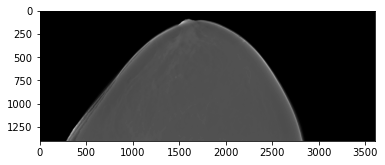

In [48]:
plt.imshow(temp[18], cmap='gray')

In [46]:
#/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-L-MLO/04069961.MG.TOMO_BILAT_SEGMENTATION.11.3.2012.11.15.15.54.20.796875.458075.IMA
p    = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04069961/LE-L-MLO/04069961.MG.TOMO_BILAT_SEGMENTATION.11.3.2012.11.15.15.54.20.796875.458075.IMA'
a    = pydicom.dcmread(p)
temp = a.pixel_array.T
temp[temp == 0] = 1
print(np.max(temp.flatten()), np.min(temp.flatten()))
temp = np.log(10000)-np.log(temp)
#temp[temp>500] = 500
print(np.max(temp.flatten()), np.min(temp.flatten()))
thresh_min      = threshold_minimum(temp)
print(temp.shape)

2000 1
9.2103405 1.609438
(2816, 3584)


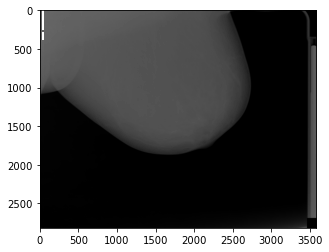

In [42]:
plt.imshow(temp, cmap='gray')

In [11]:
# Image Laterality: a.ImageLaterality (left or right)
# View Position:    a.ViewPosition (CC or MLO)
# SeriesInstanceUID (for determining the Experiment Number)
# print(a.ImageLaterality)
# print(a.ViewPosition)

print(a.StudyInstanceUID)

1.3.12.2.1107.5.12.7.1446.30000011080413494334300000023
